# 20 Newsgroups, PaCMAP version

The [PaCMAP paper](https://jmlr.org/papers/v22/20-1061.html) contains an analysis on the
[20 Newsgroups Dataset](http://qwone.com/~jason/20Newsgroups/). Images and numerical results are
presented for it, but the results are not discussed in the body of the paper, so there's not much
to do except squint at the embeddings, which at best show the typical 20NG behavior of a lot of
points squashed in the middle of the page with some points radiating out and several very small 
outlier clusters dotted around.

20NG is pretty tricky to work with in dimensionality reduction: usually you do TF-IDF on it, which
leads to a sparse matrix. PaCMAP doesn't currently support sparse data, so the usual next step is
to do PCA on it. Unfortunately, because there are a lot of features (in the 90,000 range whenever
I work with it), you need to extract a lot components to retain much of the data. This is a bit of
a challenge for the PaCMAP default of extracting 100 components only. That said, using the fully
dense 90,000D matrix is not a lot of fun either.

The [PaCMAP repo](https://github.com/YingfanWang/PaCMAP/tree/master/data) contains some data marked 
as `20NG`, so presumably that's the data that was used. Let us take a look.

In [4]:
from io import BytesIO

import httpx
import numpy as np

url = "https://github.com/YingfanWang/PaCMAP/raw/master/data/20NG.npy"

response = httpx.get(url, follow_redirects=True, timeout=10)
response.raise_for_status()

ng20 = np.load(BytesIO(response.content))

ng20.shape

[11:07:48] INFO     HTTP Request: GET                                                ]8;id=565370;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=511804;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://github.com/YingfanWang/PaCMAP/raw/master/data/20NG.npy                  
                    "HTTP/1.1 302 Found"                                                            

           INFO     HTTP Request: GET                                                ]8;id=697938;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=271444;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                    https://raw.githubusercontent.com/YingfanWang/PaCMAP/master/data                
                    /20NG.npy "HTTP/1.1 200 OK"                                                     

(18846, 100)

In [2]:
response = httpx.get(
    "https://github.com/YingfanWang/PaCMAP/raw/master/data/20NG_labels.npy",
    follow_redirects=True,
    timeout=10,
)
response.raise_for_status()

ng20_labels = np.load(BytesIO(response.content))
ng20_labels.shape, ng20_labels

((18846,), array([10,  3, 17, ...,  3,  1,  7]))

Alright, so 100D. I'll just assume that's 100 components extracted from PCA. I'm not sure what, if
any, normalization was carried out (e.g. l1 or l2 are available via `sklearn`'s TF-IDF), but it
probably doesn't matter.

In [3]:
import pandas as pd

ng20_labels = pd.DataFrame(ng20_labels, columns=["label"])

The labels are only given as integer ids, but it would have been nice to map these to the newsgroup
names. Fortunately, it looks like the data followed the outline given in the
[UMAP documentation](https://umap-learn.readthedocs.io/en/latest/document_embedding.html),
at least the same shuffling of the data has been carried out:

In [4]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset="all", shuffle=True, random_state=42)
np.all(dataset.target == ng20_labels.label)

np.True_

However after that I am not sure what processing is done. Neither the `TfIDFVectorizer` or
`CountVectorizer` approaches in the UMAP docs, followed by PCA to 100D give PaCMAP results that
resemble the results here all that closely. We can try at least to match up the newsgroup names
to the labels.

In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [7]:
index_to_name = {i: name for i, name in enumerate(dataset.target_names)}
ng20_labels["newsgroup"] = ng20_labels["label"].map(index_to_name)
ng20_labels

,label,newsgroup
0,10,rec.sport.hockey
1,3,comp.sys.ibm.pc.hardware
2,17,talk.politics.mideast
3,3,comp.sys.ibm.pc.hardware
4,4,comp.sys.mac.hardware
...,...,...
18841,13,sci.med
18842,12,sci.electronics
18843,3,comp.sys.ibm.pc.hardware
18844,1,comp.graphics


The [glasbey docs](https://glasbey.readthedocs.io/en/latest/creating_block_palettes.html) suggest
that the 20NG dataset is a good candidate for creating block palettes, where instead of having to
come up with 20 distinct colors, because the newsgroups have some overlapping topics, it would be
better to have colors that were more similar to that over-arching topic, e.g. `alt.atheism` and
`talk.religion.misc` should have similar colors. Here's the suggested topic map:

In [8]:
topic_map = {
    "comp.graphics": "Computers",
    "comp.os.ms-windows.misc": "Computers",
    "comp.sys.ibm.pc.hardware": "Computers",
    "comp.sys.mac.hardware": "Computers",
    "comp.windows.x": "Computers",
    "sci.crypt": "Science",
    "sci.electronics": "Science",
    "sci.med": "Science",
    "sci.space": "Science",
    "talk.politics.guns": "Politics",
    "talk.politics.mideast": "Politics",
    "talk.politics.misc": "Politics",
    "alt.atheism": "Religion",
    "soc.religion.christian": "Religion",
    "talk.religion.misc": "Religion",
    "rec.sport.baseball": "Sports",
    "rec.sport.hockey": "Sports",
    "rec.autos": "Cars and motorcycles",
    "rec.motorcycles": "Cars and motorcycles",
    "misc.forsale": "For Sale",
}

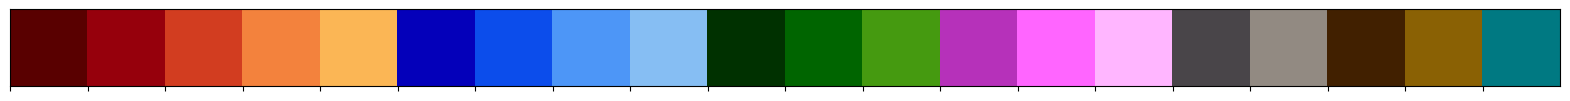

In [9]:
import glasbey
import seaborn as sns

ng20_palette = glasbey.create_block_palette([5, 4, 3, 3, 2, 2, 1])
sns.palplot(ng20_palette)

In [10]:
ng20_color_map = {"newsgroup": dict(zip(list(topic_map.keys()), ng20_palette))}
ng20_color_map

{'newsgroup': {'comp.graphics': '#590000',
  'comp.os.ms-windows.misc': '#96000c',
  'comp.sys.ibm.pc.hardware': '#d23d20',
  'comp.sys.mac.hardware': '#f3823d',
  'comp.windows.x': '#fbb655',
  'sci.crypt': '#0400ba',
  'sci.electronics': '#0c4deb',
  'sci.med': '#4d96f7',
  'sci.space': '#86bef3',
  'talk.politics.guns': '#003100',
  'talk.politics.mideast': '#006500',
  'talk.politics.misc': '#459a10',
  'alt.atheism': '#b631ba',
  'soc.religion.christian': '#ff65ff',
  'talk.religion.misc': '#ffb6ff',
  'rec.sport.baseball': '#494549',
  'rec.sport.hockey': '#928a82',
  'rec.autos': '#412000',
  'rec.motorcycles': '#8a6104',
  'misc.forsale': '#007982'}}

In [11]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "ng20pacmap",
    data=ng20,
    target=ng20_labels,
    target_palette=ng20_color_map,
    tags=["lowdim"],
    url="https://github.com/YingfanWang/PaCMAP",
    verbose=True,
)

[10:27:05] INFO     Requesting one extra neighbor to account for self-neighbor       ]8;id=529248;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=432839;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#623\623]8;;\

           INFO     Initial data shape: (18846, 100)                                  ]8;id=279486;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=799237;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=435440;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=988981;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (18846, 100)                 ]8;id=649608;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=693574;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=252068;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=865370;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (18846, 100)                     ]8;id=921289;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=895359;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#156\156]8;;\

           INFO     Checked for duplicates: found 5                                  ]8;id=588606;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=814153;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=699265;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=466878;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for ng20pacmap                                      ]8;id=969272;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=467564;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

[10:27:08] INFO     Processing target with initial shape (18846, 2)                  ]8;id=972886;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=978896;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=317011;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=257245;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for ng20pacmap                                    ]8;id=185317;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=525382;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Writing pkl format to data/ng20pacmap-target-palette.pkl         ]8;id=3257;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=47250;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#458\458]8;;\

           INFO     Calculating nearest neighbors                                    ]8;id=83488;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=980509;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#317\317]8;;\

           INFO     Loading faiss with AVX2 support.                                   ]8;id=973411;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=815463;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#110\110]8;;\

[10:27:09] INFO     Successfully loaded faiss with AVX2 support.                       ]8;id=475218;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=977943;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#112\112]8;;\

           INFO     Using 'faiss' to find nearest neighbors                           ]8;id=471103;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=113917;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#90\90]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and      ]8;id=178724;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=6647;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#103\103]8;;\
                    params: {}                                                                      

[10:27:10] INFO     Writing numpy format to                                          ]8;id=571742;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=611962;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\
                    nn/ng20pacmap.16.euclidean.exact.faiss.idx.npy                                  

[10:27:11] INFO     Writing csv format to                                            ]8;id=473149;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=334335;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\
                    nn/ng20pacmap.16.euclidean.exact.faiss.idx.csv                                  

           INFO     Writing numpy format to                                          ]8;id=895004;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=309277;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\
                    nn/ng20pacmap.16.euclidean.exact.faiss.dist.npy                                 

[10:27:12] INFO     Writing csv format to                                            ]8;id=79489;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=771545;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\
                    nn/ng20pacmap.16.euclidean.exact.faiss.dist.csv                                 

           INFO     Writing numpy format to                                          ]8;id=295741;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=243018;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\
                    nn/ng20pacmap.51.euclidean.exact.faiss.idx.npy                                  

[10:27:14] INFO     Writing csv format to                                            ]8;id=649755;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=634043;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\
                    nn/ng20pacmap.51.euclidean.exact.faiss.idx.csv                                  

[10:27:16] INFO     Writing numpy format to                                          ]8;id=445492;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=678368;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\
                    nn/ng20pacmap.51.euclidean.exact.faiss.dist.npy                                 

[10:27:17] INFO     Writing csv format to                                            ]8;id=466710;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=223480;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\
                    nn/ng20pacmap.51.euclidean.exact.faiss.dist.csv                                 

[10:27:18] INFO     Writing numpy format to                                          ]8;id=923300;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=924078;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\
                    nn/ng20pacmap.151.euclidean.exact.faiss.idx.npy                                 

           INFO     Writing csv format to                                            ]8;id=951089;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=62192;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\
                    nn/ng20pacmap.151.euclidean.exact.faiss.idx.csv                                 

[10:27:21] INFO     Writing numpy format to                                          ]8;id=161555;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=962173;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\
                    nn/ng20pacmap.151.euclidean.exact.faiss.dist.npy                                

           INFO     Writing csv format to                                            ]8;id=116831;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=501743;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\
                    nn/ng20pacmap.151.euclidean.exact.faiss.dist.csv                                

[10:27:25] INFO     Calculating triplets                                             ]8;id=538554;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=651236;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#331\331]8;;\

[10:27:26] INFO     Writing csv format to triplets/ng20pacmap.5.1337.idx.csv         ]8;id=351928;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=929117;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\

           INFO     Writing csv format to triplets/ng20pacmap.5.1337.euclidean.csv   ]8;id=980168;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=538848;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#402\402]8;;\

[10:27:27] INFO     Writing numpy format to triplets/ng20pacmap.5.1337.idx.npy       ]8;id=657873;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=285785;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\

           INFO     Writing numpy format to triplets/ng20pacmap.5.1337.euclidean.npy ]8;id=54392;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=103253;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#430\430]8;;\

           INFO     Writing pipeline result for ng20pacmap                           ]8;id=396211;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=761921;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#134\134]8;;\

[11:40:25] INFO     Getting dataset ng20pacmap                                       ]8;id=617427;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=402343;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py#246\246]8;;\

           INFO     Reading data                                                       ]8;id=217653;file:///home/james/dev/drnb3/src/drnb/io/dataset.py\dataset.py]8;;\:]8;id=635048;file:///home/james/dev/drnb3/src/drnb/io/dataset.py#74\74]8;;\

           INFO     Reading target                                                     ]8;id=361604;file:///home/james/dev/drnb3/src/drnb/io/dataset.py\dataset.py]8;;\:]8;id=656784;file:///home/james/dev/drnb3/src/drnb/io/dataset.py#78\78]8;;\

           INFO     Embedding                                                        ]8;id=9642;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=818620;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py#249\249]8;;\

           INFO     Using precomputed knn                                               ]8;id=270297;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py\pacmap.py]8;;\:]8;id=981178;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py#47\47]8;;\

           INFO     Found pre-calculated neighbors file:                             ]8;id=915375;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=135513;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#319\319]8;;\
                    nn/ng20pacmap.16.euclidean.exact.faiss.idx.npy                                  

           INFO     Converted knn to pair neighbors: (188460, 2)                        ]8;id=85845;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py\pacmap.py]8;;\:]8;id=117360;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py#58\58]8;;\

           INFO     Running PaCMAP                                                      ]8;id=976959;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py\pacmap.py]8;;\:]8;id=463317;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py#94\94]8;;\

[11:40:31] INFO     Embedding completed                                                 ]8;id=968567;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py\pacmap.py]8;;\:]8;id=869945;file:///home/james/dev/drnb3/src/drnb/embed/pacmap.py#97\97]8;;\

           INFO     Evaluating                                                       ]8;id=422899;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=931195;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py#271\271]8;;\

           INFO     rte-5-euclidean                                                       ]8;id=307022;file:///home/james/dev/drnb3/src/drnb/eval/base.py\base.py]8;;\:]8;id=88685;file:///home/james/dev/drnb3/src/drnb/eval/base.py#61\61]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=446459;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=898450;file:///home/james/dev/drnb3/src/drnb/triplets.py#283\283]8;;\

           INFO     Using triplets from triplets/ng20pacmap.5.1337.idx.npy           ]8;id=654790;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=300881;file:///home/james/dev/drnb3/src/drnb/triplets.py#295\295]8;;\

           INFO     Also found corresponding euclidean distances                     ]8;id=136302;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=169770;file:///home/james/dev/drnb3/src/drnb/triplets.py#298\298]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=165582;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=992545;file:///home/james/dev/drnb3/src/drnb/triplets.py#283\283]8;;\

           INFO     rpc-5-euclidean                                                       ]8;id=297240;file:///home/james/dev/drnb3/src/drnb/eval/base.py\base.py]8;;\:]8;id=619146;file:///home/james/dev/drnb3/src/drnb/eval/base.py#61\61]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=334043;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=463599;file:///home/james/dev/drnb3/src/drnb/triplets.py#283\283]8;;\

           INFO     Using triplets from triplets/ng20pacmap.5.1337.idx.npy           ]8;id=49584;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=32910;file:///home/james/dev/drnb3/src/drnb/triplets.py#295\295]8;;\

           INFO     Also found corresponding euclidean distances                     ]8;id=547992;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=439610;file:///home/james/dev/drnb3/src/drnb/triplets.py#298\298]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=377807;file:///home/james/dev/drnb3/src/drnb/triplets.py\triplets.py]8;;\:]8;id=627239;file:///home/james/dev/drnb3/src/drnb/triplets.py#283\283]8;;\

           INFO     nnp-[15, 50, 150]-noself-euclidean                                    ]8;id=782647;file:///home/james/dev/drnb3/src/drnb/eval/base.py\base.py]8;;\:]8;id=464467;file:///home/james/dev/drnb3/src/drnb/eval/base.py#61\61]8;;\

[11:40:33] INFO     Plotting                                                         ]8;id=335221;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py\pipeline.py]8;;\:]8;id=116429;file:///home/james/dev/drnb3/src/drnb/embed/pipeline.py#281\281]8;;\

           INFO     Not showing large legend                                          ]8;id=924527;file:///home/james/dev/drnb3/src/drnb/plot/seaborn.py\seaborn.py]8;;\:]8;id=403645;file:///home/james/dev/drnb3/src/drnb/plot/seaborn.py#114\114]8;;\

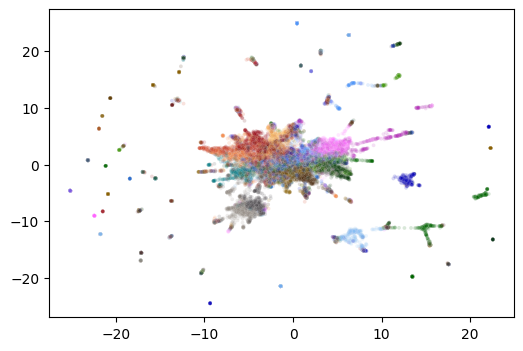

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6680568820969967), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.51930535), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.20610562807315436), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.25768757295977934), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.274664473451484), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [ ]:
import drnb.embed.pipeline as pl

pl.standard_eval(
    "pacmap",
    dataset="ng20pacmap",
)

This is pretty close to what is in Figure 22 of the paper.